# Data Analyst vs. Data Scientist: Unveiling the Salary Divide in the World of Data

## Introduction

Understanding average salaries and differences between roles is crucial for making informed decisions aligning with personal aspirations and financial goals in a data-related career (Kaur et.al, 2022). Here we delve into the realm of data careers **to compare the average income of employees (USD) in two different data-related roles ("Data Analyst" vs "Data Engineer") and  then determine if there’s a significant difference between the two groups**. This will provide valuable insights for those seeking to carve their path in the world of data.

This dataset describes 12 attributes, of which we will focus on the specific ones listed below: 

`job_title` : The role worked during the year, focusing on “Data Analyst” and “ Data Science”.

`salary_in_usd`: The salary in USD. 

For our location parameter, we have chosen the mean to help determine the central tendency of the two groups and identify roles with higher or lower average salaries. The scale parameter, standard deviation, measures income variability. Comparing the standard deviations of the two groups reveals salary variation within each role: a smaller deviation indicates more consistency, while a larger deviation indicates greater variability. 

Let $\bar{x}_1$ be the mean salary for a data analyst and $\bar{x}_2$ be the mean salary for a data engineer. Now, we can declare our two hypotheses:

$H_0$: $\bar{x}_1$ = $\bar{x}_2$. There is no difference in the mean salaries between a data analyst and data engineer.

$H_1$: $\bar{x}_1 \neq \bar{x}_2$. There is a difference in the mean salaries between a data analyst and data engineer.

We aim to assess whether any observed differences in the sample mean (average salaries) between the two groups are due to random chance or if they represent a real difference in the population means. 

## Preliminary Results

In [32]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(scales)
library(cowplot)
library(digest)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [33]:
# setting seed for entire project
set.seed = 4850

Download the dataset from the url and store it into a local file.

In [34]:
url = 'https://raw.githubusercontent.com/aaryan-rampal/stat-201-project/main/data/ds_salaries.csv'

download.file(url, destfile = "data/ds_salaries.csv")

Read the file into the dataframe `salary_original`. We will need to wrangle this original dataframe by selecting our columns of interest and filtering `NA` values. 

In [35]:
salary_original <- read_csv("data//ds_salaries.csv")

# clean up columns 
salary <- salary_original |>
    select(job_title, salary_in_usd) |>
    filter(!is.na(salary_in_usd), 
           !is.na(job_title),
           (job_title == "Data Analyst" | job_title == "Data Scientist")) |>
    # overwrite job_title to be of type factor
    mutate(job_title = as_factor(job_title)) 
    

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [36]:
head(salary, 6)
table(select(salary, job_title))

job_title      salary_in_usd
1 Data Scientist 79833        
2 Data Analyst   72000        
3 Data Scientist 35735        
4 Data Scientist 51321        
5 Data Scientist 40481        
6 Data Scientist 39916


Data Scientist   Data Analyst 
           143             97 

It looks like `salary` has been wrangled properly and contains a fair amount of datapoints for both job titles. 

Let's visualize the sampling distribution of salaries for both jobs. 

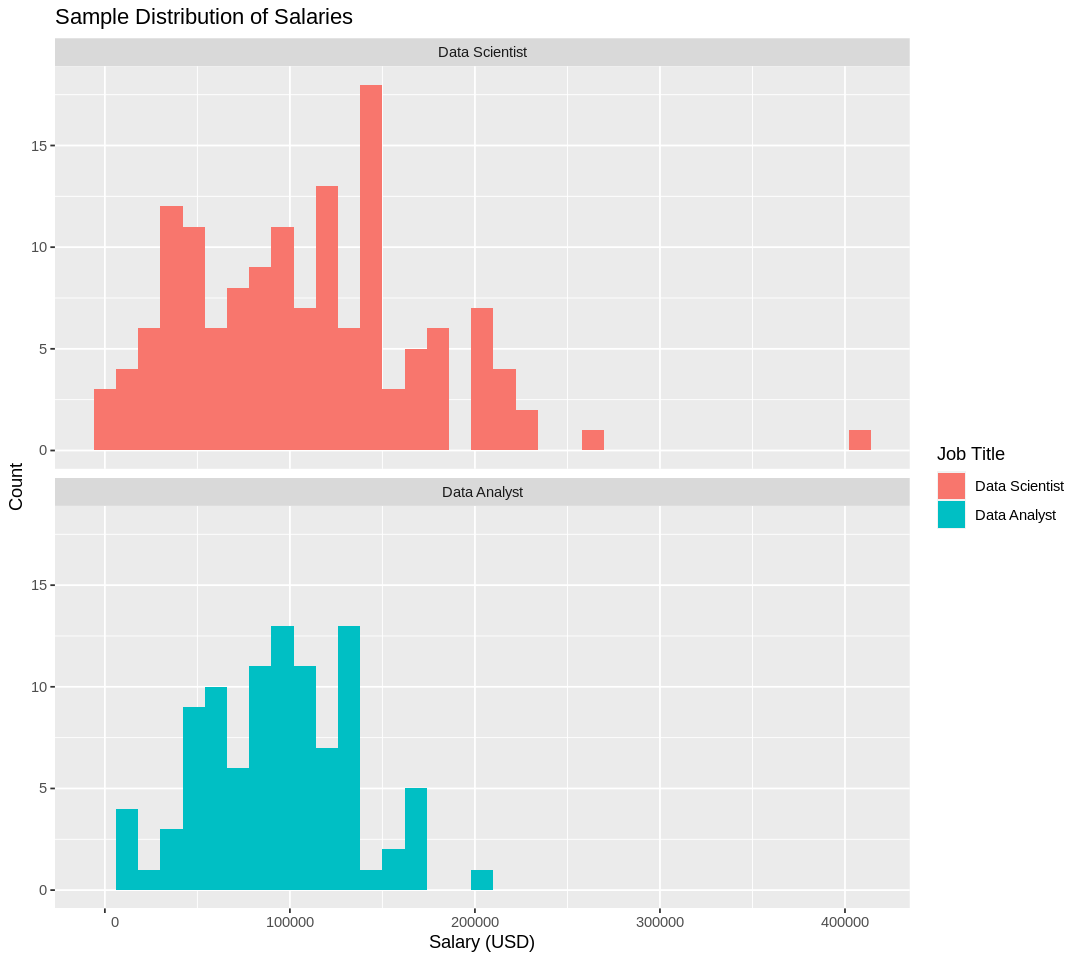

In [37]:
options(repr.plot.height = 8, repr.plot.width = 9)

# visualization of original data sample
salary_sample_dist <- salary |>
    ggplot(aes(x = salary_in_usd, fill = job_title)) +
    geom_histogram(binwidth = 12000) +
    facet_wrap(~ job_title, ncol = 1) +
    ggtitle("Sample Distribution of Salaries") +
    xlab("Salary (USD)") +
    ylab("Count") +
    labs(fill = "Job Title") + 
    scale_x_continuous(labels = function(x) format(x, scientific = FALSE))

salary_sample_dist

The sampling distribution for both job titles appears to be pretty similar, though it does seem there are quite a few data scientists that are paid more than data analysts. This could also just be the outliers in our data, let's visualize our data using a boxplot to gain more information.

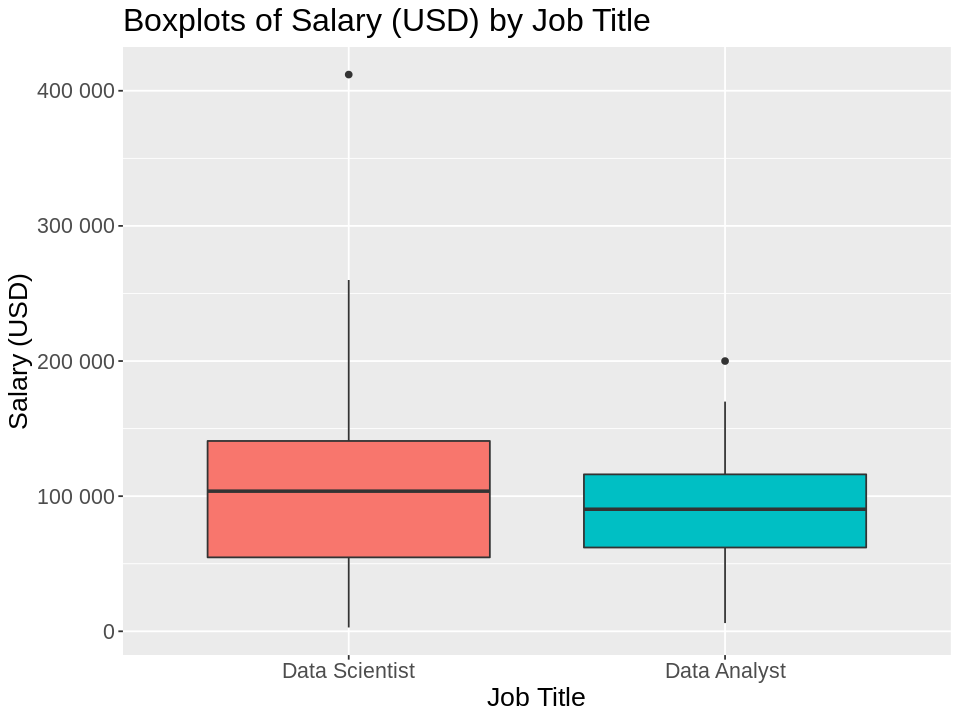

In [44]:
options(repr.plot.height = 6, repr.plot.width = 8)

salary_boxplot <-
    salary %>% 
    ggplot() +
    geom_boxplot(aes(job_title, salary_in_usd, fill=job_title)) +
    theme(text = element_text(size = 16)) +
    ggtitle("Boxplots of Salary (USD) by Job Title") + 
    xlab("Job Title") + 
    ylab("Salary (USD)") +  
    guides(fill = "none") +
    scale_y_continuous(labels = label_number(scale = 1))

salary_boxplot

As can be seen, it looks like the mean values for salary for both job titles is very similar. The data analyst box plot seems to be more tightly populated than the data scientist box plot, hinting at a smaller standard deviation.

Moreover, we can see the extent of the data scientist outliers. There is an outlier at around $400,000 USD which is quite far outside the range of normal values for data scientist. This could be the reason why the data scientist mean salary is greater than the data analyst's. 

At a preliminary glance, it looks like data analysts are paid less on average when compared to data scientists. But is this difference significant? This is what we shall attempt to find out.

## Methods: Plan

Given our approach using hypothesis testing to compare the average income of jobs titled “Data Analyst” and “Data Engineer”, we are testing our assumptions prior to actuating them. This results in a trustworthy report as the premises carried over from the hypothesis test will be verified for future implementation to the broader population. 

Although current visualizations and estimates provide a brief understanding of the dataset, they cannot be generalized or alluded to the entire field of data-related careers. As we plan to carry out a hypothesis test upon the average income for both job titles, a confidence interval will also be constructed for sampling distributions of the average income for both job titles. 

We expect to estimate the true population parameter of mean income for two job titles as well as test our hypothesis that the average income for the two job titles are significantly different. This report is intended to provide support for those making choices about the pursuit of one’s profession and may evidently lead to questions regarding the difference in difficulty or commitment of data-related careers based on the income.


In [45]:
# compute summary statistics for each job title
salary_summarized <- salary |>
    group_by(job_title) |>
    summarize(n = n(),
              sample_mean = mean(salary_in_usd),
              sample_var = sd(salary_in_usd)^2)

salary_summarized

job_title      n   sample_mean sample_var
1 Data Scientist 143 108187.83   4110456319
2 Data Analyst    97  92893.06   1596887583

### Two Sample T-Test

Now that we have our summarized statistics about the two job titles, we can do a two sample t-test on our data. The two sample t-test is a method which can be used to help us determine if there is a significant difference between the means of two groups.

Since this is not a paired t-test, it is fine if our two groups do not have the exact same number of values (which, as we have noted before, they don't).

In [51]:
# two sample t-test
t_test_results <- tidy(
                   t.test(x = salary %>% filter(job_title == "Data Scientist") %>% pull(salary_in_usd), 
                          y = salary %>% filter(job_title == "Data Analyst") %>% pull(salary_in_usd),
                          alternative = "two.sided"))

t_test_results

estimate estimate1 estimate2 statistic p.value    parameter conf.low
1 15294.77 108187.8  92893.06  2.274778  0.02381541 236.4901  2048.91 
  conf.high method                  alternative
1 28540.63  Welch Two Sample t-test two.sided

In [52]:
test_stat <- t_test_results |>
    select(statistic) |>
    pull()

p_value <- t_test_results |>
    select(p.value) |>
    pull()

Since the p-value < 0.05, we already know that the difference between the two means are statistically significant under a 5% significance level.

However, we can go a little bit further to visualize this p-value which we received from the test.

In [53]:
df <- nrow(salary) - 2
t_values <- seq(-4, 4, by = 0.01)  # Adjust the range and increment as needed
probabilities <- dt(t_values, df = df)

t_dist_data <- data.frame(t = t_values, p = probabilities)

In [48]:
ci <- tibble(lower = qt(0.025, df),
             upper = qt(0.975, df))

ci

lower     upper   
1 -1.969982 1.969982

In [49]:
# Create the ggplot plot
t_dist <- ggplot(t_dist_data, aes(x = t, y = p)) +
    geom_line(color = "blue") +
    labs(title = "T-Distribution (df = 238)", x = "t-value", y = "Probability") +
    geom_ribbon(data = t_dist_data %>% filter(t >= ci$lower & t <= ci$upper),
                aes(ymin = 0, ymax = p), 
                fill = "blue", alpha = 0.3) +
    geom_vline(xintercept = test_stat, color = 'red') +
    geom_vline(xintercept = ci$lower, size = 1) +
    geom_vline(xintercept = ci$upper, size = 1)

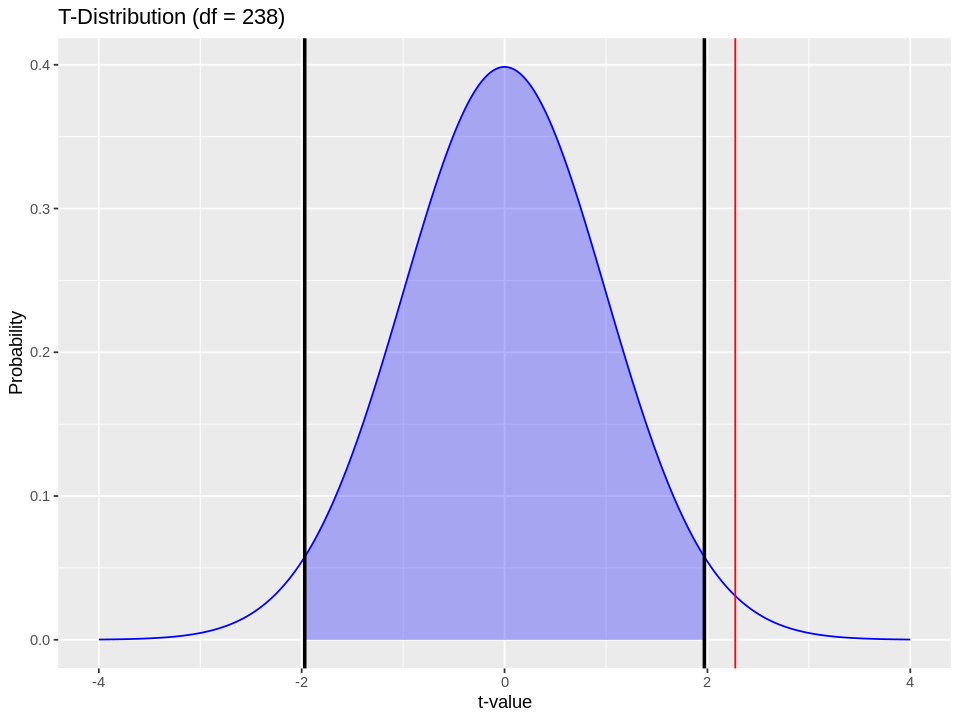

In [50]:
t_dist

We can visually see that our test-statistic falls outside the 95% confidence interval.  

### CLT WAY using worksheet 7

In [ ]:
data_scientist <- 
    salary %>% 
    filter(job_title == 'Data Scientist') %>% 
    pull(salary_in_usd)

data_analyst <- 
    salary %>% 
    filter(job_title == 'Data Analyst') %>% 
    pull(salary_in_usd)


penguins_diff_means_ci <- 
    tibble(
        lower_ci = mean(data_scientist) - mean(data_analyst) - qnorm(0.975, mean = 0, sd = 1) * sqrt(var(data_scientist)/length(data_scientist) + var(data_analyst)/length(data_analyst)),
        upper_ci = mean(data_scientist) - mean(data_analyst) + qnorm(0.975, mean = 0, sd = 1) * sqrt(var(data_scientist)/length(data_scientist) + var(data_analyst)/length(data_analyst))
    )

penguins_diff_means_ci

We can see that the null model, where $u_1 - u_2 = 0$, does not fall within the 95% confidence interval. 

### TESTING DIFFERENCE IN STANDARD DEVIATION

We would like to also examine the difference between our scale parameter of choice, the standard deviation of salary for the two job titles of “Data Analyst” and “Data Engineer”. Aforementioned in our introduction, the standard deviation will reveal income variability which can tell us whether the difference in spread between the two populations is truly different or not. Let's focus on the standard deviation of data scientists and test if this measure of spread is truly different from that of data analysts. To test this difference, we will carry out a bootstrap hypothesis test using a significance level of $\alpha = 0.05$ on the difference in standard deviation, as follows.

Since we do not know either the true standard deviation for data analysts and data scientists, let us first use bootstraping to approximate the sampling distribution of data analysts. We will set the true standard deviation for data analysts to the mean of this sampling distribution for the purpose of our hypothesis test

In [13]:
# create single sample of data analysts from filtering only that job title 
data_analyst <- salary |>
    filter(job_title == "Data Analyst") 

# use bootstrapping to calculate standard deviation for 1000 bootstrapped samples
data_analyst_bootstrap <- data_analyst |>
    specify(response = salary_in_usd) |>
    generate(reps = 1000, type = "bootstrap") |>
    calculate("sd")

# by CLT, the mean of the bootstrap distribution is equal to the true population parameter
sd_data_analyst <- data_analyst_bootstrap |>
    summarise(true_sd = mean(stat)) 

sd_data_analyst

true_sd
1 39634.3

As bootstrap distributions are a good estimate of sampling distributions, and assuming that our original sample for data analysts of $n = 97$ is sufficiently large, we estimate the true standard deviation for data analysts to be $\sigma_2 = 39606.04$. We will use this value to carry out a hypothesis test on the standard deviation for data scientists where the true standard deviation is also unknown. 

Let $\sigma_1$ be the standard deviation of salary for a data scientist and $\sigma_0$ be equal to $\sigma_2 = 39606.04$ which is the true standard deviation of salary for a data analyst. Now, we can declare our null and alternate hypotheses:

$H_0$: $\sigma_1$ = $39606.04$. The standard deviation of salaries for data scientists is equal to that of data analysts.

$H_1$: $\sigma_1 \neq 39606.04$. There is a difference in the standard deviation of salaries between a data analyst and data scientists.

In [56]:
sigma_0 <- 39606.04

# create data frame of only data scientists
data_scientist <- salary |>
    filter(job_title == "Data Scientist")

# simulating from null distribution 
null_data_scientist <- data_scientist |>
  specify(response = salary_in_usd) |>
  hypothesize(null = "point", sigma = sigma_0) |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "sd")

head(null_data_scientist)

replicate stat    
1 1         68788.58
2 2         65531.53
3 3         68597.53
4 4         63004.23
5 5         64113.26
6 6         69964.23

Now that we have the simulated null distribution, we will use the standard deviation of the data scientists sample for our test statistic.

In [57]:
# get the observed test statistic which is the standard deviation of the original sample for data scientists
obs_test_stat <- data_scientist |>
    summarise(sd = sd(salary_in_usd)) |>
    pull()

obs_test_stat

[1] 64112.84

Plotting the result of the hypothesis test from above.

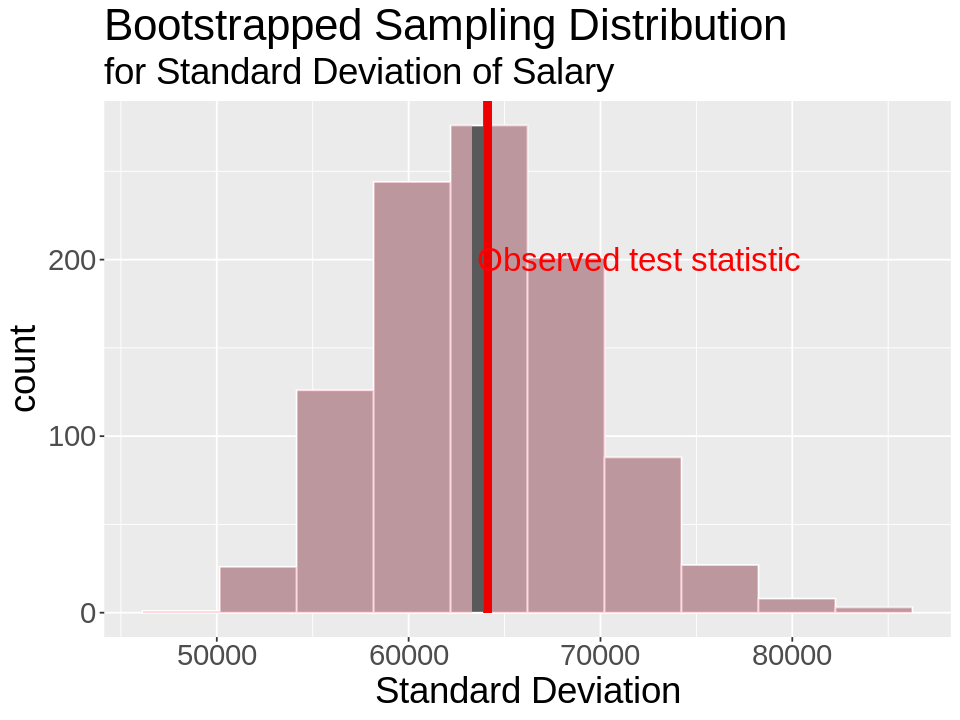

In [58]:
data_scientist_plot <-  
    null_data_scientist %>% 
    visualize(bins = 10) + 
    shade_p_value(obs_stat = obs_test_stat, direction = "both") +
    xlab("Standard Deviation") + 
    theme(text = element_text(size=22)) + 
    ggtitle("Bootstrapped Sampling Distribution", subtitle = "for Standard Deviation of Salary") +
    annotate("text", x = 72000, y = 200, label = "Observed test statistic", color="red", size=7)

data_scientist_plot

By the definition of the p-value, it looks like it will be very large visually inferred from the plot above. Let's get a numerical value for the p-value next.


In [17]:
p_value <- null_data_scientist |>
    get_p_value(obs_stat = obs_test_stat, direction = "both")

p_value

p_value
1 0.916

Given our pre-sepcified $\alpha = 0.05$, the p-value is significantly greater than that. Thus, we conclude that we fail to reject the null hypothesis, $H_0$, and that there is not enough evidence to support that there is a difference in the true standard deviations of salary for data scientists and data analysts.


## References

T. Z. Quan and M. Raheem, "Salary Prediction in Data Science Field Using Specialized Skills and Job Benefits–A Literature", Journal of Applied Technology and Innovation, vol. 6, no. 3, pp. 70-74, 2022, ISSN 2600-7304.

A. Kaur, D. Verma and N. Kaur, "Utilizing Quantitative Data Science Salary Analysis to Predict Job Salaries," 2022 2nd International Conference on Innovative Sustainable Computational Technologies (CISCT), Dehradun, India, 2022, pp. 1-4, doi: 10.1109/CISCT55310.2022.10046491.